In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sns

In [2]:
df = pd.read_excel(r"C:\Users\Dnin\Desktop\bidnet_dataset_01242024.xlsx")
df.head()

,Title,Description,Tags,Relevant?
0,"E-Rate Cat. 2 - Wireless Network, UPS units, D...",The Denver Public Library (DPL) is seeking pro...,None,No
1,009-24 RFP Interpretation and Translation Serv...,DCSD is requesting proposals from qualified fi...,None,No
2,Survive and Thrive: Application and Payment Pr...,Boulder County Department of Housing and Human...,None,No
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System En...,None,No
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“Universi...,None,No


In [3]:
model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [4]:
# keywords = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
#             "salesforce", "grants", "licensing and permits", "lightning experience, lightning migration",\
#             "case management", "data warehouse", "automation", "rpa ; robotic process automation" , "consultancy", "advisory",\
#            "application development and maintenance"]

keywords = ["digital transformation","artificial intelligence", "machine learning", "analytics",\
            "salesforce", "grants", "licensing and permits", "lightning experience, lightning migration",\
            "case management", "data warehouse", "automation", "rpa ; robotic process automation"]

keyword_embeddings = np.array([model.encode(keyword) for keyword in keywords])

In [5]:
def calculate_cosine_similarity(description_embedding):
    similarities= {}
    for keyword, keyword_embedding in zip(keywords, keyword_embeddings):
        similarity = cosine_similarity([keyword_embedding], [description_embedding])[0][0]
        similarities[keyword] = similarity
        #print(f"Similarity with '{keyword}':", similarities[keyword])
        
    return similarities

def predict_tags(row, model, keywords, keyword_embeddings, threshold):
    description = row['Description']
    actual_tags = "No Tags" if row['Tags'] == "None" else row['Tags']
    description_embedding = model.encode(description)
    
    similarities_tags = calculate_cosine_similarity(description_embedding)

#     threshold = 0.3
#     For second model threshold around 0.6
#     predicted_tags = [keyword for keyword, score in similarities_tags.items() if score > threshold]

    filtered_sorted_tags = sorted([(keyword, score) for keyword, score in similarities_tags.items() if score > threshold], key=lambda x: x[1], reverse=True)
    top_3_tags = [tag for tag, _ in filtered_sorted_tags[:3]]
#     print("Description:", description)
#     print("Actual Tags: ", actual_tags)
#     print("Predicted Tags: ", predicted_tags)
#     print("Most Relevant Tag: " max_similarity_tag)
    
    return top_3_tags

def check_relevance(row):
    relevance = "Yes" if len(row['Most Relevant Tags']) > 0 else "No"
    return relevance

In [6]:
# Assuming 'model', 'keywords', 'keyword_embeddings' are defined
df['Most Relevant Tags'] = df.apply(lambda row: predict_tags(row, model, keywords, keyword_embeddings, 0.3), axis=1)

In [7]:
df['Predicted Relevance'] = df.apply(check_relevance, axis=1)
df

,Title,Description,Tags,Relevant?,Most Relevant Tags,Predicted Relevance
0,"E-Rate Cat. 2 - Wireless Network, UPS units, D...",The Denver Public Library (DPL) is seeking pro...,None,No,[data warehouse],Yes
1,009-24 RFP Interpretation and Translation Serv...,DCSD is requesting proposals from qualified fi...,None,No,[],No
2,Survive and Thrive: Application and Payment Pr...,Boulder County Department of Housing and Human...,None,No,[],No
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System En...,None,No,[],No
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“Universi...,None,No,[],No
5,Enterprise Resource Planning Readiness Consultant,Procure a consultant to conduct a needs assess...,None,No,"[data warehouse, digital transformation]",Yes
6,NaN,The District seeks to gather information on po...,None,No,[],No
7,Electronic Case Management for City Prosecutor...,It is the intent of the City of Westminster (C...,Case Management,Yes,"[case management, data warehouse, digital tran...",Yes
8,Software and Implementation Services for an En...,Proposals will only be accepted from those fir...,None,No,[data warehouse],Yes
9,BD2429: Digital Adoption Platform (DAP),Digital Adoption Platform license to use for i...,"Digital Transformation, Licensing and Permits",Yes,"[licensing and permits, digital transformation...",Yes


In [8]:
df['Relevant?'] = df['Relevant?'].map({'Yes': True, 'No': False})
df['Predicted Relevance'] = df['Predicted Relevance'].map({'Yes': True, 'No': False})
recall = recall_score(df['Relevant?'], df['Predicted Relevance'])
print("Recall: " ,recall)

Recall:  1.0


In [9]:
conf_mat = confusion_matrix(df['Relevant?'], df['Predicted Relevance'])
conf_mat

array([[ 6,  3],
       [ 0, 13]], dtype=int64)

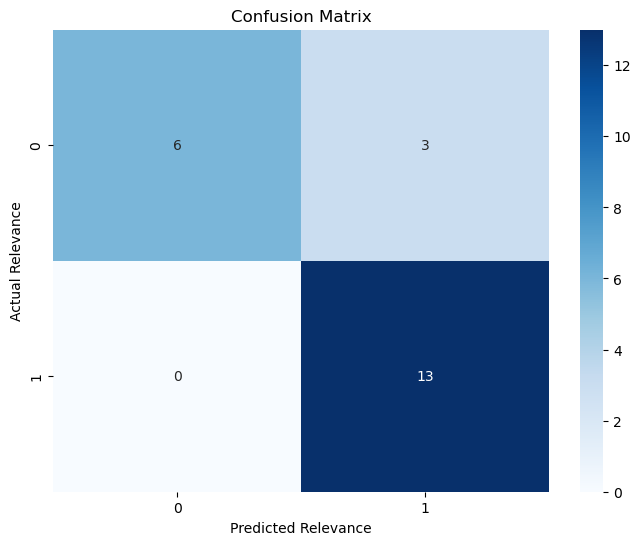

In [10]:
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Relevance')
plt.ylabel('Actual Relevance')
plt.show()